In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

In [2]:
spark = SparkSession.builder.appName("DataProcessing").getOrCreate()

file_path = "Processed_Merged_Dataset.csv"
merged_df = spark.read.csv(file_path, header=True, inferSchema=True)

country_development = {
    'developed': ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 
                  'Iceland', 'Ireland', 'Italy', 'Japan', 'Luxembourg', 'Netherlands', 'New Zealand', 
                  'Norway', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States'],
    'developing': ['Argentina', 'Brazil', 'China', 'India', 'Indonesia', 'Mexico', 'Russia', 'South Africa', 
                   'Turkey', 'Malaysia', 'Thailand', 'Vietnam', 'Philippines', 'Egypt', 'Nigeria', 'Pakistan'],
    'underdeveloped': ['Afghanistan', 'Chad', 'Mali', 'Burundi', 'Sierra Leone', 'Somalia', 'Central African Republic']
}

def categorize_country(country):
    for key, value in country_development.items():
        if country in value:
            return key
    return 'to_remove'  

categorize_country_udf = udf(categorize_country, StringType())

merged_df = merged_df.withColumn('country_development', categorize_country_udf(col('location')))

merged_df = merged_df.filter(merged_df.country_development != 'to_remove')


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/07 05:32:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/07 05:32:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
columns_to_remove = ['iso_code', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 
                     'Unnamed: 13', 'CODE', 'location', 'date', 'total_cases', 'total_deaths', 
                     'stringency_index', 'population', 'gdp_per_capita', 'human_development_index']
merged_df = merged_df.drop(*columns_to_remove)
print("Columns in the cleaned dataset:")
print(merged_df.columns)

Columns in the cleaned dataset:
['HDI', 'TC', 'TD', 'STI', 'POP', 'GDPCAP', 'country_development']


In [5]:
import os
import shutil

In [6]:
output_folder = "TempOutputFolderForUpdatedData"
output_file_path = os.path.join(output_folder, "part-00000-*.csv")

merged_df.coalesce(1).write.csv(output_folder, mode="overwrite", header=True)

for filename in os.listdir(output_folder):
    if filename.startswith("part-00000"):
        shutil.move(os.path.join(output_folder, filename), "Updated_Merged_Dataset.csv")

shutil.rmtree(output_folder)

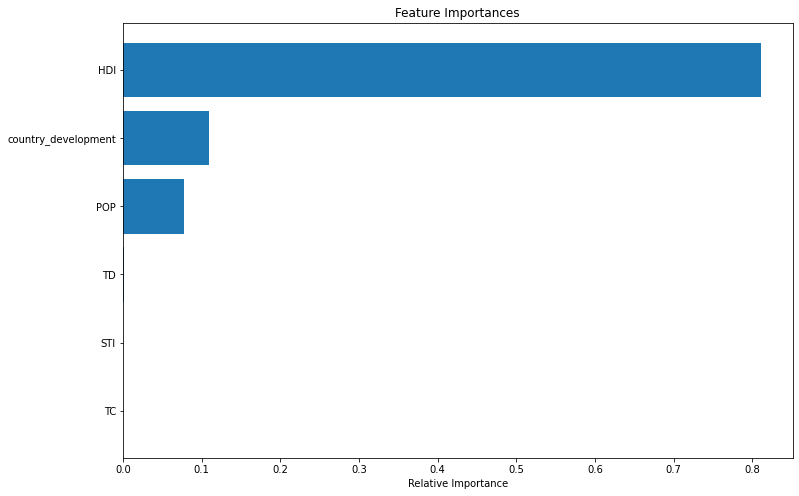

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

merged_df = pd.read_csv('Updated_Merged_Dataset.csv')

label_encoder = LabelEncoder()
merged_df['country_development'] = label_encoder.fit_transform(merged_df['country_development'])

selected_features = ['country_development', 'HDI', 'TC', 'TD', 'STI', 'POP']

X = merged_df[selected_features]
y = merged_df['GDPCAP']

model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()